In [1]:
from qiskit import *
from IPython.display import clear_output
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.errors import pauli_error, depolarizing_error
from qiskit.providers.aer.noise import thermal_relaxation_error

In [2]:
def make_noise(p_cx=0,T1T2Tm=(1,1,0)):
    '''
        Returns a noise model specified by the inputs
        - p_cx: probability of depolarizing noise on each
                qubit during a cx
        - T1T2Tm: tuple with (T1,T2,Tm), the T1 and T2 times
              and the measurement time
    '''
    
    noise_model = NoiseModel()
    
    # depolarizing error for cx
    error_cx = depolarizing_error(p_cx, 1)
    error_cx = error_cx.tensor(error_cx)
    noise_model.add_all_qubit_quantum_error(error_cx, ["cx"])
    
    # thermal error for measurement
    (T1,T2,Tm) = T1T2Tm
    error_meas = thermal_relaxation_error(T1, T2, Tm)
    noise_model.add_all_qubit_quantum_error(error_meas, "measure")
        
    return noise_model

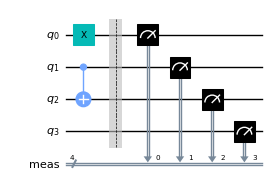

In [3]:
qc = QuantumCircuit(4)
qc.x(0)
qc.cx(1,2)
qc.measure_all()
qc.draw(output='mpl', scale=0.5)

In [4]:
execute( qc, Aer.get_backend('qasm_simulator'), shots=8192).result().get_counts()


{'0001': 8192}

In [5]:
noise_model = make_noise(p_cx=0.1)
execute( qc, Aer.get_backend('qasm_simulator'), noise_model=noise_model, shots=8192).result().get_counts()

{'0111': 22, '0011': 383, '0101': 381, '0001': 7406}

In [6]:
for Tm in (0.01,0.1,1,10):
    noise_model = make_noise(p_cx=0, T1T2Tm=(1,1,Tm))
    counts = execute( qc, Aer.get_backend('qasm_simulator'), noise_model=noise_model, shots=8192).result().get_counts()
    print('Tm =',Tm,', counts =',counts)


Tm = 0.01 , counts = {'0000': 68, '0001': 8124}
Tm = 0.1 , counts = {'0000': 747, '0001': 7445}
Tm = 1 , counts = {'0001': 3044, '0000': 5148}
Tm = 10 , counts = {'0000': 8192}


In [7]:
from qiskit.ignis.verification.topological_codes import RepetitionCode
from qiskit.ignis.verification.topological_codes import GraphDecoder
from qiskit.ignis.verification.topological_codes import lookuptable_decoding, postselection_decoding

/tmp/ipykernel_5079/2472739805.py:1: DeprecationWarning: The qiskit.ignis package is deprecated and has been supersceded by the qiskit-experiments project. Refer to the migration guide: https://github.com/Qiskit/qiskit-ignis#migration-guide on how to migrate to the new project.
  from qiskit.ignis.verification.topological_codes import RepetitionCode


In [8]:
d = 4
T = 1
code = RepetitionCode(d,T)

In [9]:
code.circuit


{'0': <qiskit.circuit.quantumcircuit.QuantumCircuit at 0x7f2ad2f2cc10>,
 '1': <qiskit.circuit.quantumcircuit.QuantumCircuit at 0x7f2ad2f2cc70>}

In [10]:
code.circuit['0'].draw(output='text')


┌───┐          ┌───┐             ┌─┐               
      link_qubit_0: ┤ X ├──────────┤ X ├─────────────┤M├───────────────
                    └─┬─┘┌───┐     └─┬─┘┌───┐        └╥┘┌─┐            
      link_qubit_1: ──┼──┤ X ├───────┼──┤ X ├─────────╫─┤M├────────────
                      │  └─┬─┘┌───┐  │  └─┬─┘┌───┐    ║ └╥┘┌─┐         
      link_qubit_2: ──┼────┼──┤ X ├──┼────┼──┤ X ├────╫──╫─┤M├─────────
                      │    │  └─┬─┘  │    │  └─┬─┘┌─┐ ║  ║ └╥┘         
      code_qubit_0: ──■────┼────┼────┼────┼────┼──┤M├─╫──╫──╫──────────
                           │    │    │    │    │  └╥┘ ║  ║  ║ ┌─┐      
      code_qubit_1: ───────■────┼────■────┼────┼───╫──╫──╫──╫─┤M├──────
                                │         │    │   ║  ║  ║  ║ └╥┘┌─┐   
      code_qubit_2: ────────────■─────────■────┼───╫──╫──╫──╫──╫─┤M├───
                                               │   ║  ║  ║  ║  ║ └╥┘┌─┐
      code_qubit_3: ───────────────────────────■───╫──╫──╫──╫──╫──╫─┤M├
                                                   ║  ║  ║  ║  ║  ║ └╥┘
round_0_link_bit: 3/═══════════════════════════════╬══╩══╩══╩══╬══╬══╬═
                                                   ║  0  1  2  ║  ║  ║ 
        code_bit: 4/═══════════════════════════════╩═══════════╩══╩══╩═
                                                   0           1  2  3

In [11]:
code.circuit['1'].draw(output='text')


┌───┐          ┌───┐             ┌─┐               
      link_qubit_0: ─────┤ X ├──────────┤ X ├─────────────┤M├───────────────
                         └─┬─┘┌───┐     └─┬─┘┌───┐        └╥┘┌─┐            
      link_qubit_1: ───────┼──┤ X ├───────┼──┤ X ├─────────╫─┤M├────────────
                           │  └─┬─┘┌───┐  │  └─┬─┘┌───┐    ║ └╥┘┌─┐         
      link_qubit_2: ───────┼────┼──┤ X ├──┼────┼──┤ X ├────╫──╫─┤M├─────────
                    ┌───┐  │    │  └─┬─┘  │    │  └─┬─┘┌─┐ ║  ║ └╥┘         
      code_qubit_0: ┤ X ├──■────┼────┼────┼────┼────┼──┤M├─╫──╫──╫──────────
                    ├───┤       │    │    │    │    │  └╥┘ ║  ║  ║ ┌─┐      
      code_qubit_1: ┤ X ├───────■────┼────■────┼────┼───╫──╫──╫──╫─┤M├──────
                    ├───┤            │         │    │   ║  ║  ║  ║ └╥┘┌─┐   
      code_qubit_2: ┤ X ├────────────■─────────■────┼───╫──╫──╫──╫──╫─┤M├───
                    ├───┤                           │   ║  ║  ║  ║  ║ └╥┘┌─┐
      code_qubit_3: ┤ X ├───────────────────────────■───╫──╫──╫──╫──╫──╫─┤M├
                    └───┘                               ║  ║  ║  ║  ║  ║ └╥┘
round_0_link_bit: 3/════════════════════════════════════╬══╩══╩══╩══╬══╬══╬═
                                                        ║  0  1  2  ║  ║  ║ 
        code_bit: 4/════════════════════════════════════╩═══════════╩══╩══╩═
                                                        0           1  2  3